In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.models as models
from torch.utils.data import DataLoader
import foolbox
from foolbox.models import PyTorchModel

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [28]:
root = os.path.join('.', 'dataset_root')
mean, std = [0.13066046], [0.30150425] # based on training set
batch_size = 64
lr = 0.01
momentum=0.9
step_size=10
gamma=0.1
epochs = 20
model_path = 'mnist_cnn.pt'

In [29]:
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)])
train_dataset = tv.datasets.MNIST(
    root,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    root,
    train=False, 
    download=True,
    transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [30]:
# https://foolbox.readthedocs.io/en/stable/modules/models.html#foolbox.models.PyTorchModel
# "It should predict logits or log-probabilities, i.e. predictions without the softmax."
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # remove the softmax layer
        output = F.log_softmax(x, dim=1)
        return x

In [31]:
model = Net()
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)

In [32]:
def validate(model, loader):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            # this log function is not suitable
            loss = F.nll_loss(output, y)
            total_loss += loss.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [33]:
# TODO: loss is NOT correct!
va_loss, va_acc = validate(model, test_loader)
print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

Test Loss: -21.2682 Accuracy: 99.1000%


In [34]:
x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)
output = model(x)
print(output.size())
print(output[:5])

torch.Size([64, 10])
tensor([[ 2.3710e+01, -8.0733e+00,  1.9657e-02, -1.0803e+01, -7.6144e+00,
          1.7828e-01,  7.6318e+00, -7.5327e+00, -1.0084e+00,  2.8643e+00],
        [-3.4426e+00,  2.1216e+01,  1.6238e-01, -6.1112e+00,  3.0153e+00,
         -3.4610e+00, -1.0369e+00,  2.0348e+00, -6.7121e-01, -9.1889e+00],
        [-6.1461e+00,  5.3426e+00,  6.3487e+00,  4.0475e+00, -4.8787e+00,
         -1.0792e+01, -1.4921e+01,  2.0808e+01, -3.6810e+00,  1.2887e+00],
        [ 6.3932e-01, -6.5975e+00, -1.1331e+01,  2.4911e+00, -8.9728e+00,
          2.3088e+01, -2.3571e+00, -2.1367e+00, -8.2435e-01,  7.5108e+00],
        [-1.0237e+01,  1.8211e+00, -5.1365e+00, -4.3989e+00,  2.6865e+01,
         -5.0445e+00, -8.6280e+00,  2.9588e+00, -1.8095e+00,  6.2504e+00]],
       device='cuda:0', grad_fn=<SliceBackward>)


In [35]:
preprocessing = {'mean': mean, 'std': std, 'axis': -1}  # for single channel
fmodel = PyTorchModel(
    model, 
    bounds=(0, 1), 
    num_classes=10, 
    preprocessing=preprocessing,
    channel_axis=1,
    device=device)

In [36]:
images, labels = next(iter(test_loader))
images = images.numpy()
labels = labels.numpy()
print(images.shape, labels.shape)
assert type(images) == np.ndarray

(64, 1, 28, 28) (64,)


In [37]:
output = fmodel.forward(images)
pred = output.argmax(axis=-1)
print(output.shape)
accuracy = np.mean(pred == labels)
print(accuracy)

(64, 10)
0.96875


In [38]:
images = images * std + mean
images = np.clip(images, 0, 1)
print(images.shape)
images = images.astype(np.float32)
print(images.dtype)

(64, 1, 28, 28)
float32


(28, 28)


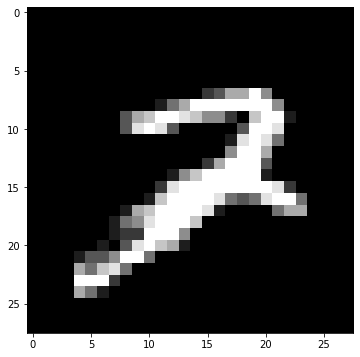

In [39]:
image = np.squeeze(np.transpose(images[0], (1, 2, 0)))
print(image.shape)

plt.figure(figsize=[6, 6])
plt.imshow(image, cmap='gray', vmin=0., vmax=1.)
plt.show()

In [40]:
attack = foolbox.attacks.FGSM(
    fmodel,
    criterion=foolbox.criteria.Misclassification()
)
adversarials = attack(images, labels, max_epsilon=0.15)
print(adversarials.shape)
print(np.mean(fmodel.forward(adversarials).argmax(axis=-1) == labels))

(64, 1, 28, 28)
0.0625


(28, 28)
(28, 28)
0.0 0.0
(28, 28)


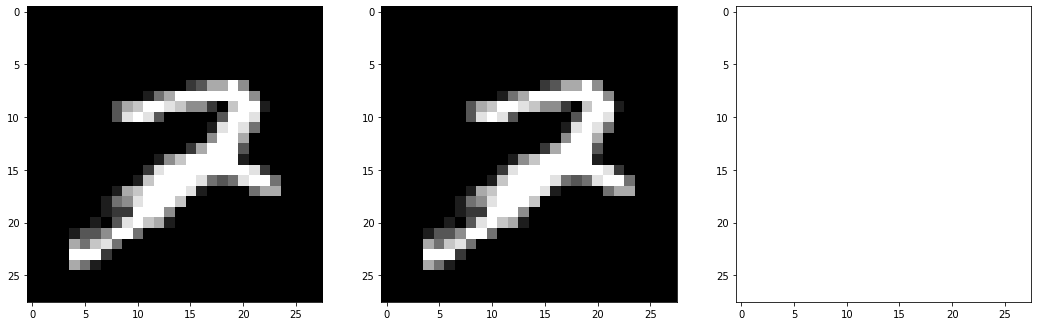

In [41]:
image = np.squeeze(np.transpose(images[0], (1, 2, 0)))
print(image.shape)
# ad = np.transpose(adversarials[0].perturbed, (1, 2, 0))
ad = np.squeeze(np.transpose(adversarials[0], (1, 2, 0)))
print(ad.shape)

p = ad - image
imax = np.max(p)
imin = np.min(p)
print(imax, imin)
p = (p - imin)/ (imax-imin)
print(p.shape)

plt.figure(figsize=[18, 6])
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0., vmax=1.)
plt.subplot(1, 3, 2)
plt.imshow(ad, cmap='gray', vmin=0., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(p, cmap='gray', vmin=0., vmax=1.)
plt.show()

In [42]:
ad_tensor = torch.tensor(adversarials, dtype=torch.float32)
print(ad_tensor.size())
ad_tensor = ad_tensor.to(device)
ad_out = model(ad_tensor)
print(ad_out.shape)
preds = ad_out.max(1, keepdim=True)[1]

for i, p in enumerate(preds, 0):
    if p.item() != y[i]:
        print(f'[{i:2d}] pred={p.item()} label={y[i]}')
    

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])
[ 0] pred=7 label=0
[ 2] pred=1 label=7
[ 3] pred=9 label=5
[ 4] pred=9 label=4
[ 5] pred=1 label=5
[ 7] pred=9 label=3
[ 8] pred=1 label=2
[ 9] pred=1 label=9
[10] pred=1 label=4
[11] pred=1 label=9
[12] pred=1 label=9
[13] pred=3 label=9
[14] pred=7 label=3
[15] pred=1 label=6
[16] pred=5 label=0
[17] pred=5 label=6
[18] pred=3 label=4
[19] pred=6 label=9
[20] pred=1 label=0
[22] pred=1 label=7
[23] pred=2 label=1
[24] pred=1 label=6
[25] pred=8 label=4
[26] pred=8 label=6
[27] pred=1 label=6
[29] pred=8 label=1
[30] pred=1 label=0
[31] pred=1 label=8
[32] pred=1 label=4
[33] pred=1 label=8
[34] pred=1 label=8
[35] pred=1 label=7
[36] pred=1 label=8
[37] pred=1 label=6
[38] pred=1 label=0
[39] pred=1 label=6
[40] pred=1 label=2
[41] pred=1 label=3
[42] pred=9 label=3
[43] pred=7 label=5
[44] pred=1 label=9
[45] pred=1 label=0
[46] pred=6 label=5
[47] pred=8 label=9
[49] pred=1 label=2
[50] pred=5 label=0
[51] pred=1 label=2
[52] pred=1